In [1]:
# plot libs
import matplotlib as mpl, matplotlib.pyplot as plt, pandas as pd
import seaborn as sns, numpy as np, pickle, json
from IPython.display import Image
%matplotlib inline
# structure manipuations libs
from pymatgen import Structure, Composition
from pymatgen.core.surface import Slab, SlabGenerator
from pymatgen.analysis.structure_analyzer import SpacegroupAnalyzer
from pymatgen.transformations.advanced_transformations import SlabTransformation
# workflow libs
from hetero2d.manipulate.heterotransmuter import hetero_interfaces

/home/tboland1/anaconda3/envs/cms/lib/python3.6/site-packages/pymatgen/__init__.py:35: UserWarning: With effect from pmg 5.0, all pymatgen settings are prefixed with a "PMG_". E.g., "PMG_VASP_PSP_DIR" instead of "VASP_PSP_DIR".
  warnings.warn('With effect from pmg 5.0, all pymatgen settings are'
/home/tboland1/anaconda3/envs/cms/lib/python3.6/site-packages/mpinterfaces/__init__.py:45: UserWarning: Check your mpint_config.yaml potentials path
  warnings.warn('Check your mpint_config.yaml potentials path')


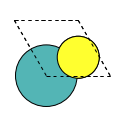

In [2]:
# import example data structures
filename = 'example_structs.pkl'
with open(filename, 'rb') as p:
    struct_2d, struct_3d2d, struct_bulk, struct_sub = pickle.load(p)
Image(filename='mos2.png',embed=True)

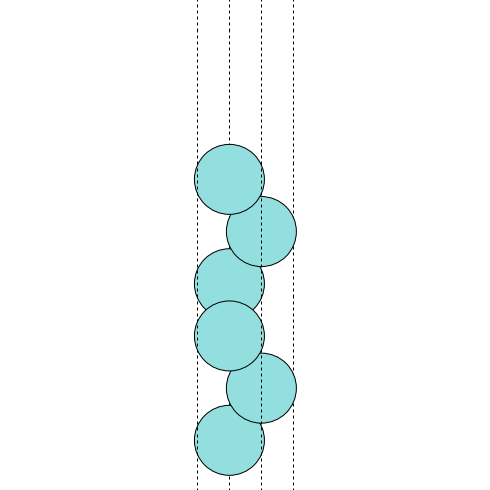

In [3]:
Image(filename='zr.png',embed=True)

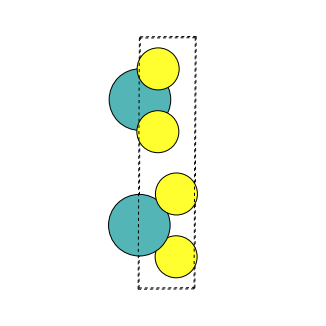

In [4]:
Image(filename='bulkcounterpart.png',embed=True)

# Creating hetero-interface structures

In [5]:
# heterointerfaces module input values
max_area, max_mismatch = 80, 0.05
max_angle_diff, separation = 1, 3
r1r2_tol, nlayers_2d = 0.01, 3
nlayers_sub = 1

In [6]:
# slab generation params
lll_reduce, max_normal_search, center_slab, primitive = True, True, True, True
in_unit_planes = False
min_vacuum_size, min_slab_size, shift, tol = 18, 12, 0, 0.1

In [7]:
# Create 111 substrate surfaces
miller_index = [1,1,1]
struct = SpacegroupAnalyzer(struct_bulk).get_conventional_standard_structure()
st = SlabTransformation(miller_index, min_slab_size, min_vacuum_size, lll_reduce, 
            center_slab, in_unit_planes, primitive, max_normal_search, shift, tol)
struct_slab = st.apply_transformation(struct)

In [8]:
# create heterointerface structs & store structs in iface_out
iface_out = hetero_interfaces(struct_2d, struct_sub, max_mismatch, max_area, nlayers_2d, nlayers_sub, 
            r1r2_tol, max_angle_diff, separation)

rmax1, rmax2: 9, 9


MATCH FOUND

u,v & angle mismatches:
-0.0008767653502491646, -0.0008769404292973126, 4.932076819841313e-06



In [9]:
alignment_params = iface_out.pop(-1)
print(alignment_params)

{'opt_uv1': [array([3.19595400e+00, 0.00000000e+00, 1.95695742e-16]), array([-1.59797700e+00,  2.76777800e+00,  1.95695776e-16])], 'opt_uv2': [array([ 1.59657597e+00, -2.76535065e+00, -1.95524163e-16]), array([1.59657597e+00, 2.76535065e+00, 3.91048328e-16])], 'u': -0.0008767653502491646, 'v': -0.0008769404292973126, 'angle': 4.932076819841313e-06, 'tm1': array([[ 1,  0],
       [ 0, -1]]), 'tm2': array([[ 0, -1],
       [-1, -1]]), 'fu_2d': 1.0, 'fu_sub': 1.0}


# Running Heterostructure Workflow

In [10]:
# required variables and python libraries
from hetero2d.workflow import get_heterostructures_stabilityWF
from hetero2d.io.VaspInterfaceSet import CMDLInterfaceSet
from fireworks import LaunchPad
host='host'
name='the name of the database to submit the workflow to'
username='your username for the database'
password='the password for your username'

The user must always provide the workflow with the path the vasp executable.

The parameter *bin_2d* allows the user to supply the path to an executable for VASP compiled to prevent the 2D material's vacuum spacing from shrinking. 

In [11]:
# set the path to the 2D and 3D vasp version
bin_2d = 'srun --mpi=pmi2 /path/to/remote/vasp_std_2D' 
bin_3d = 'srun --mpi=pmi2 /path/to/remote/vasp_std_3D' 

In [12]:
uis = dict(EDIFF  = 0.0001, EDIFFG = -0.05, IBRION = 2,
    POTIM = 0.15, ISPIN = 1, NSW = 500, NELMDL = -6)

The parameter *slab_params* is used to create the substrate surface slab within the Firework from a bulk structure. The input parameters are the same as the pymatgen *SlabTransformation* input parameters.

In [13]:
slab_params = {'transformations': ['SlabTransformation'],
    'transformation_params': [{'miller_index': [1,1,1], 'lll_reduce': True, 'max_normal_search': True,
        'min_vacuum_size': 18, 'primitive': False, 'min_slab_size': 12, 'center_slab': True}]}

The parameter *heterotransformation_params* is used to create the hetero-interface structures subject to the constraints listed below.

In [14]:
heterotransformation_params=[{'max_mismatch': 0.05, 
    'max_area': 100, 'max_angle_diff': 1, 'r1r2_tol': 0.1, 
    'nlayers_2d': 3, 'nlayers_sub': 2, 'separation': 3}]

The parameter *user_additions* is used to configure the spec file for all the fireworks in the workflow. The minimum required parameters to supply is listed below. 

The *unique_id* is appended to each firework to track fireworks in the workflow in the database.

*analysis_info* is used to supply energetic information to fireworks in the workflow to determine the stability of the hetero-structure.

*orient* is the miller index of the substrate surface.

In [15]:
user_additions = {'unique_id': 1, 'analysis_info': [{}],
    'orient': [1,1,1]}

In [16]:
wf = get_heterostructures_stabilityWF(struct_2d, struct_bulk, 
    struct_3d2d, heterotransformation_params, slab_params, 
    user_additions, bin_2d=bin_2d, bin_3d=bin_3d, uis=uis)

Workflow Name: MoS2-on-Zr: hkl-[111]: 1
{-1: [-2], -2: [-5], -3: [-5, -4], -4: [-5], -5: []}


In [ ]:
# send the wf to the launch pad
lp = LaunchPad(host=host, port=27017, name=name,
               username=username, password=password)

In [13]:
lp.add_wf(wf)

2021-09-02 19:32:50,234 INFO Added a workflow. id_map: {-5: 25, -4: 26, -3: 27, -2: 28, -1: 29}


{-5: 25, -4: 26, -3: 27, -2: 28, -1: 29}

# Analyze Results

In [17]:
# import data from Hetero2d Workflow 
with open('2d_substrate_heterostructures.json','r') as f:
    data = json.load(f)

In [18]:
# set up pandas dataframe
ads_energy = pd.DataFrame(columns=['name', 'uid', 'surf', 'e_bind', 'e_ads', 'film', 'config'])
for objectID, fw in data.items():
    film, conf = fw['film_composition'], fw['Interface Config']
    uid, surf = fw['unique_id'], fw['surface_plane']
    e_ads = fw['Adsorption_Energy']['E_ads']
    e_bind = fw['Binding_Energy']['E_bind']
    sgn = fw["film_spacegroup"]["number"]
    name = film+'-'+fw['substrate_composition']+'-'+str(uid)

    if sgn == 187 and film == 'NbO2':
        film = film+'-2H'
    elif sgn == 164 and film == 'NbO2':
        film = film+'-1T'     

    data_ads = {'name': name, 'film': film, 'uid': uid, 
        'surf': surf, 'config': conf, 'e_bind': e_bind, 'e_ads': e_ads}
    pdd = pd.DataFrame(data=[data_ads])
    ads_energy = ads_energy.append(pdd, ignore_index=True) 

## Adsorption Formation Energy Plot

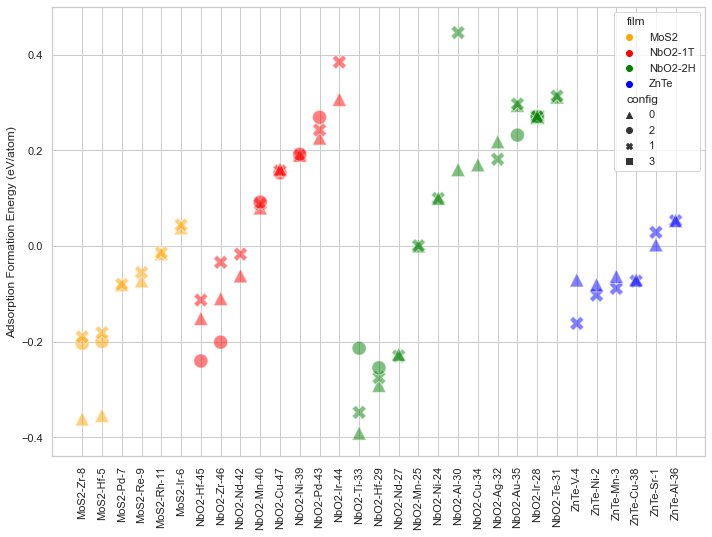

In [19]:
# adsorption formation energy: 111
sns.set(style="whitegrid", rc={'figure.figsize':(11.7,8.27)})
ads_111 = ads_energy[ads_energy.surf == '111']
ads = ads_111.sort_values(by=['film','e_ads'])
ax = sns.scatterplot(x="name", y="e_ads", data=ads, hue='film', 
                     style='config', s=200, markers=['^','o','X','s'], alpha=0.5, 
                     palette=['orange','red','green','blue'])
ax.set(ylabel='Adsorption Formation Energy (eV/atom)',xlabel='',
       ylim=(round(min(ads.e_ads),2)-0.05,round(max(ads.e_ads),2)+0.05))
plt.xticks(rotation=90)
fig = ax.get_figure()

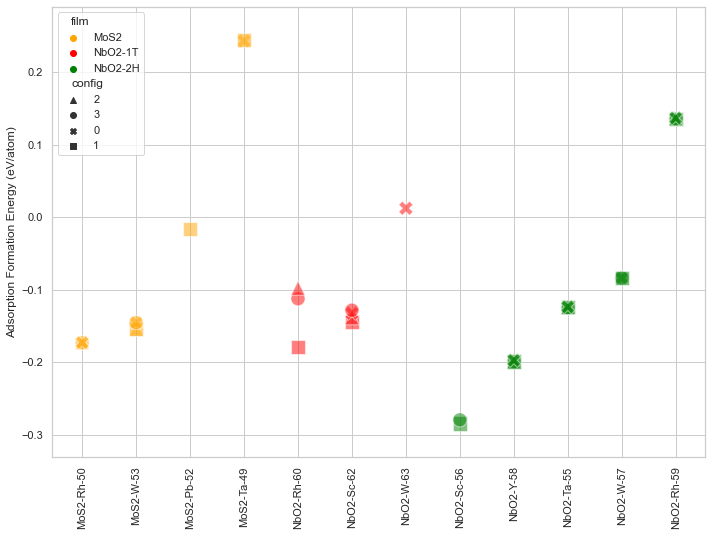

In [20]:
# adsorption formation energy: 011
ads_011 = ads_energy[ads_energy.surf == '011']
ads = ads_011.sort_values(by=['film','e_ads'])
ax = sns.scatterplot(x="name", y="e_ads", data=ads, hue='film', 
                     style='config', s=200, markers=['^','o','X','s'], alpha=0.5, 
                     palette=['orange','red','green'])
ax.set(ylabel='Adsorption Formation Energy (eV/atom)',xlabel='',
       ylim=(round(min(ads.e_ads),2)-0.05,round(max(ads.e_ads),2)+0.05))
plt.xticks(rotation=90)
fig = ax.get_figure()